## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

In [5]:
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


c. The number of unique users in the dataset.

In [6]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [7]:
len(df[df['converted'] == 1])/len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
len(df[(df['landing_page'] == 'new_page') & (df['group'] != 'treatment') |
  (df['landing_page'] == 'old_page') & (df['group'] != 'control')])

3893

f. Do any of the rows have missing values?

In [9]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
wrong = df[(df['landing_page'] == 'new_page') & (df['group'] != 'treatment') | (df['landing_page'] == 'old_page') & (df['group'] != 'control')]
df2 = df.drop(wrong.index)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates()

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
len(df2[df2['converted'] == 1]) / len(df2)

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [44]:
control_conv = len(df2[(df2['converted'] == 1) & (df2['group'] == 'control')]) / len(df2[df2['group'] == 'control'])
control_conv 

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [46]:
trt_conv =  len(df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')]) / len(df2[df2['group'] == 'treatment'])
trt_conv

0.11880724790277405

In [45]:
obs_diff = trt_conv - control_conv
obs_diff

-0.0015790565976871451

d. What is the probability that an individual received the new page?

In [19]:
len(df2[df2['landing_page'] == 'new_page']) / len(df2)

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

#### Not sufficient. Eventhough the probability of converted user in tretment group is slightly lower than control group, doesn't necessarily represent the entire population since it's not statistically tested or proven to be true.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null hypothesis: the treatment group performs equal or less compare the control group

#### Alternative hypothesis: the treatment group performs better compare the control group

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [20]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [31]:
# the number of converted / total number of view
P_new = (df2.converted == 1).mean()

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [32]:
P_old = (df2.converted == 1).mean()

c. What is $n_{new}$, the number of individuals in the treatment group?

In [33]:
len(df2[df2['landing_page'] == 'new_page'].user_id.unique())

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
len(df2[df2['landing_page'] == 'old_page'].user_id.unique())

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
N_new = 145310
new_page_converted = np.random.choice([0,1],145310, p=(P_new,1-P_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [35]:
N_old = 145274
old_page_converted = np.random.choice([0,1],145274, p=(P_old,1-P_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [36]:
new_page_converted.mean() - old_page_converted.mean()

0.0008901830055147997

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [37]:
p_diffs = []
new_converted_simulation = np.random.binomial(N_new, P_new, 10000)/N_new 
old_converted_simulation = np.random.binomial(N_old, P_old, 10000)/N_old 
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  24.,  167.,  754., 1729., 2698., 2509., 1457.,  511.,  135.,
          16.]),
 array([-0.00413201, -0.00328331, -0.00243461, -0.00158591, -0.00073721,
         0.00011149,  0.00096019,  0.00180889,  0.00265759,  0.00350629,
         0.00435499]),
 <BarContainer object of 10 artists>)

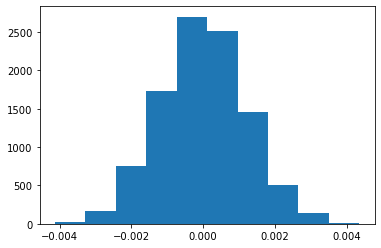

In [38]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [47]:
(p_diffs > obs_diff).mean()

0.9046

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### Since Type I error rate is 5%, we fail to reject the null hypothesis because proportion of p_diffs > 0.05. We can conclude that at 0.05 significance level, the old page has higher probablity of convert rate than new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

N_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
N_old = df2.query('landing_page == "old_page"')['user_id'].nunique() 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [68]:
from statsmodels.stats.proportion import proportions_ztest

In [71]:
z, p_val = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([N_new,N_old]), alternative = 'larger')
z, p_val

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### Since the p value is greater than 0.05 significance level, we fail to reject the null hypothesis that old page users has a better or equal converted rate than old page users. There's no differnce on converted rate for new page and old page have no difference. The result is same as parts J and K. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### logistic regression - binary classification

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [72]:
df2['intercept'] = 1
df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [75]:
df2['ab_page'] = np.where(df2['group'] == 'treatment', 1, 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [83]:
lo = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = lo.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [84]:
print(result.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-10 06:19 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### p-value for ab_page is 0.1897
#### null hypothesis: there is no difference between the treatment and control group.
#### Alternative hypotheses: there is difference between between the treatment and control group
#### In this section we have incorporated additional factors into the experiment which is to dynamically look at the difference between conversion rate in control and trt group.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### We could also look into the time stamp variable and see if that affect the conversion rate. One way is to group the time stamp by day/week/month and converted into dummy variables and add to the logistic model. The potential disadvantages could be the model tend to overfit when adding to many variables, or the model can be difficult to interpret with many variables init. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [86]:
country = pd.read_csv('countries.csv')
country.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [89]:
country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [88]:
fulldf = df2.merge(country, on = 'user_id')
fulldf.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US


In [90]:
fulldf = fulldf.join(pd.get_dummies(fulldf['country']))

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1


In [91]:
fulldf = fulldf.drop(columns = ['CA'])
fulldf.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,1


In [93]:
logitmodel = sm.Logit(fulldf['converted'], fulldf[['intercept','new_page','UK','US']])
result1 = logitmodel.fit()
result1.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-10 06:30 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2486  0.0000  -2.0822  -1.9778
new_page      -0.0150    0.0114   -1.3076  0.1910  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5159  0.1296  -0.0119   0.0934
==================================================================

"""

#### Seems like the country dummies are not significant at 0.05 significance level

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [97]:
fulldf['UKinteraction'] = fulldf['new_page']* fulldf['UK']
fulldf['USinteraction'] = fulldf['new_page']* fulldf['US']
logitmodel2 = sm.Logit(fulldf['converted'], fulldf[['intercept','new_page','UK','US','UKinteraction','USinteraction']])
result2 = logitmodel2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-10 06:37 AIC:              212782.9124
No. Observations:   290585           BIC:              212846.3903
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept         -2.0040   0.0364 -55.0077 0.0000 -2.0754 -1.9326
new_page          -0.0674   0.0520  -1.2967 0.1947 -0.1694  0.0345
UK                 0.0118   0.0398   0.2957 0.7674 -0.0663  0.0899
US                 0.0175   0.0377   0.4652 0.6418 -0.0563  0.0914
UKinteraction      0.0783   0.0568   1.3783 0.1681 -0.0330  0.1896
USinteraction      0.0469   0.0538   0.8716 0.3834 -0.0585  0.1523
==================================================================

"""

#### The new variables are still not significant at 0.05 significance level. After we conducted statistical experiment and still not proven that new page is performing better than old page, we should not adopt the new page.

In [98]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0